# Digital recognizer
importation of the training dataframe

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('./train/train.csv')
df_train = df_train[0:1000]
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y = np.array(df_train['label'])                 # reading the label column
y = y.reshape( (y.shape[0],1) )                 # reshaping for more explicit dimensions
y[y != 4] = 0.0
y[y == 4] = 1.0
df_train = df_train.drop('label', axis = 1)     # remove the column containg the y values, we specifie the axis so that pandas know where to look for 'label'
df_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
### Global variables
HEIGHT_PXL = 28
WIDTH_PXL = 28
NB_FRAMES = df_train.shape[0]

Lecture puis affichage d'une frame depuis le dataFrame

Digit : 0


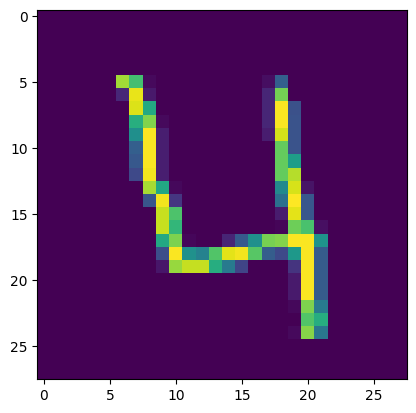

In [11]:
def DisplayDigit(ind):
    Z = df_train.iloc[ind]                  # acces based on the index
    print(f"Digit : {Z[0]}")                # state associated to the frame

    Frame1 = np.array(Z)
    Frame1 = Frame1.reshape((HEIGHT_PXL,WIDTH_PXL))

    fig = plt.figure()
    im = plt.imshow(Frame1)

DisplayDigit(3)

Creation of the logistic model
under the form $ h(x, \theta0 +x1*\theta1 + x2*\theta2 + ... + xm*\thetam)$

In [13]:
NB_PARAMS = 1+HEIGHT_PXL*WIDTH_PXL                      # number of parameters to optimize
Theta0 = np.random.rand( NB_PARAMS,1)                   # creation of the vector of parameters
Theta = Theta0

def Phi0(xi):
    return 1

def Phik(xi, k):
    return xi[k]

def ComputeX():
    X = np.empty( (NB_FRAMES, NB_PARAMS) )

    for row in range(NB_FRAMES):                         # on balaye chaque ligne du dataframe
        xi = df_train.iloc[row]                                       
        X[row,0] = Phi0(xi)                                  
        for col in range(1, NB_PARAMS):
            X[row,col] = Phik(xi,col-1)                  # (col-1) parce que 1 parametre de plus que de nb de pixel (le parametre constant)
    
    return X

def sigmoid(x):
    sig =  1/(1 + np.exp(-x))
    sig = np.maximum(0.00001, sig)                       
    sig = np.minimum(0.99999, sig)                       # saturation to avoid the 1 that causes log problem
    return sig


In [14]:
def GetPhiVec(xi):
    Phi_vec = np.empty( (NB_PARAMS,1))
    
    Phi_vec[0] = Phi0(xi)
    for i in range(1,HEIGHT_PXL*WIDTH_PXL):
        Phi_vec[i] = Phik(xi,i)
    
    return Phi_vec


def ComputeDecisionVec(Theta):
    h_vec = np.empty( (NB_FRAMES,1))
    for i in range(NB_FRAMES):

        # reading and extracting the i-th row of the data frame
        xi = np.array(df_train.iloc[i])
        xi = xi.reshape( (xi.shape[0],1) )

        Phi_vec = GetPhiVec(xi)

        h_vec[i] = sigmoid( np.matmul( np.transpose(Theta),Phi_vec ) )
    
    return h_vec

array([[0.9999],
       [0.9999],
       [0.9999],
       [0.9999],
       [0.9999],
       [0.9999],
       [0.9999],
       [0.9999],
       [0.9999],
       [0.9999]])

Cost function

In [15]:
def ComputeCost(h_vec):
    J = -sum(y * np.log(h_vec) + (1-y) * np.log(1 - h_vec))
    return J

def ComputeGrad(h_vec):
    X_t = np.transpose( ComputeX() )
    h_vec = ComputeDecisionVec(Theta)
    grad = np.matmul( X_t, (h_vec - y))
    return grad


(785, 1)

/tmp/ipykernel_10382/1469681430.py:23: RuntimeWarning: overflow encountered in exp
  sig =  1/(1 + np.exp(-x))


ValueError: x and y must have same first dimension, but have shapes (20,) and (50, 1)

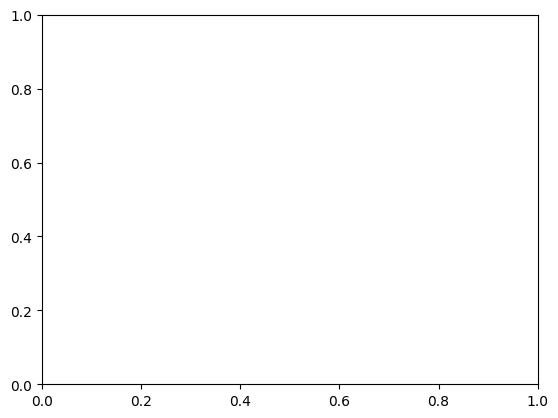

In [17]:
Theta = Theta0
alpha = 0.00005
nb_it = 15
cost = np.empty((nb_it,1))
for i in range(nb_it):
    h_vec = ComputeDecisionVec(Theta)
    cost[i] = ComputeCost(h_vec)
    grad_i = ComputeGrad(h_vec)
    Theta = Theta -alpha*grad_i

fig, ax = plt.subplots()
ax.plot(range(20),cost,'-b')
plt.show()
    

